#ID2225 Final Project: Visual Search Systems as Learning Machines
Marcos Fernández Carbonell

<center><img src="https://drive.google.com/uc?id=1eyIQKMXYwSUUuesDKbGhW2vYuLjgaXl7" alt="The discopter Alexander Weygers"/></center>

# 1.Abstract
This project aims to develop, train and test a visual search system that is able to detect the presence of objects in images. It also presents how these systems could be improved by using the scheme of a Learning Machine (LM), a system that actively learns. First, some basic aspects about visual search systems are discussed. Second, a vocabulary is implemented, trained and tested. Last, a possible Learning Machines' perspective of the project is presented. 

# 2.Goals

The main goals of this project are:


*   Developing a visual search system based on a vocabulary tree to detect the presence of objects in images
*   Thinking and writing about the Learning Machines' perspective on this kind of system


# 3.Visual search system basis

One of the most critical factors in object recognition is the fact of dealing with huge databases in a reasonable amount of time. When trying to implement a visual search system, comparing all the query descriptors with all the database ones might be a naive and unwise approach since it would be absurdly slow. One solution that has been widely used to tackle this problem is to cluster the descriptors into visual words. 


For using this idea, it will be necessary to build a visual vocabulary. Figure 1 details the process of creating and using a visual vocabulary. In (a), feature descriptors are extracted from images and used to fill the feature subspace. In (b), features are clustered to quantize the space into a discrete number of visual words. In (c), a new image is used as a query image and the nearest visual word is identified for each one of its keypoints.  Finally, in (d) a bag-of-visual-words histogram is used to represent the image and match it with the most similar one [1].

<center><img src="https://drive.google.com/uc?id=1M3-Flcijr3mQSiNtKeG-W1IPfV6hIhX4" alt="Visual vocabulary img"/></center>


<center>Figure 1. Creation of a visual vocabulary. Source: [1]</center>

In order to make clustering scalable and efficient to a large number of objects, I will base my implementation on the recognition scheme (Vocabulary Tree) proposed by David Nistér and Henrik Stewénius in [2]. 

In this paper, SIFT descriptors are used as features. The vocabulary tree is built by hierarchical k-means clustering, which defines a hierarchical quantization. Furthermore TF-IDF score is used for object retrieval.

TF-IDF score:

$w_{ij}=\frac{f_{ij}}{F_{j}}log_{2}\left ( \frac{K}{K_{i}} \right )$

Where:

*   $f_{ij}$: number of occurrences of word $v_{i}$ in object $o_{j}$
*   $F_{j}$: total number of visual words in object $o_{j}$
*   $K_{i}$: number of objects that contain the word $v_{i}$
*   $K$: total number of objects

An array of TF-IDFs scores is calculated for each leaf node, where the higher the probability of a word belonging to an object is, the higher the score of that index is.


Hierarchical k-means pseudocode:
```
function Hierarchical k-means(data,k,depth)
  Initialization of the tree
  Recurse(data,k,depth,nodeno=0,current_depth=0)
  function Recurse(data,k,nodeno,current_depth)
    if current_depth == depth OR len(data)<k then
      Calculate tf-idf score
      Create leaf nodes and add them to the vocabulary tree
      break
    else
      clusters = k-means(data,k)
      Add new clusters to the vocabulary tree
      for i=1:k do
        Recurse(clusters(i),k,current_nodeno,current_depth)
      end for
    end if-else statement
  end function
end function
```




#  4.Code

In the following sections, I will develop and test a visual search system based on a vocabulary tree.



## 4.1. Setting up the environment 

In [0]:
# Install OpenCV library
pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10

     |████████████████████████████████| 15.5MB 291kB/s 
     |████████████████████████████████| 21.4MB 1.5MB/s 
ERROR: dopamine-rl 1.0.5 has requirement opencv-python>=3.4.1.15, but you'll have opencv-python 3.3.0.10 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
# Mount the Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_path = 'gdrive/My Drive/KTH/ID2225/Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Import libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm_notebook
import pandas as pd

##   4.2. Testing OpenCV and SIFT


For extracting keypoints and computing descriptors I will use the open source library [OpenCV](https://docs.opencv.org/3.4/d5/d3c/classcv_1_1xfeatures2d_1_1SIFT.html).

Number of columns (len(descriptors)): 128
Number of rows (# of features): 150


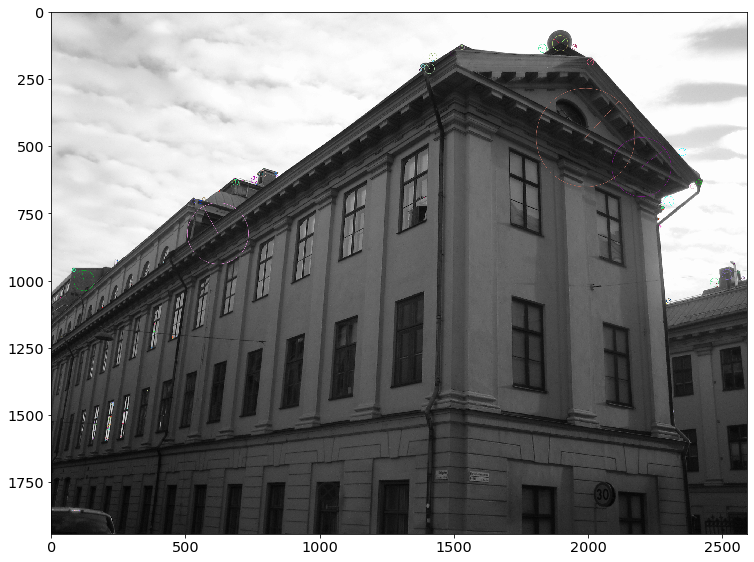

In [0]:
# SIFT parameters
max_num_features = 150  # Max number of features (number of best features to retain)
con_th = 0.1            # Define contrast threshold (the larger the threshold, the less features are produced by the detector)
edg_th = 8              # Define the threshold used to filter out edge-like features (the larger the threshold, the less features are filtered out)
sig =  1.8              # Define the sigma of the Gaussian applied to the input image at the octave #0 (if your image is captured with a weak camera with soft lenses, you might want to reduce the number)


img = cv.imread(os.path.join(root_path, 'data', 'server', 'obj26_1.JPG')) # Load an image 
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)                                 # Image to grayscale
sift = cv.xfeatures2d.SIFT_create(nfeatures=max_num_features,             # Create an object of the SIFT class with the above parameters
                                  contrastThreshold=con_th,
                                  edgeThreshold=edg_th,
                                  sigma=sig)
kp, des = sift.detectAndCompute(gray,None)                                # Detect keypoints
img = cv.drawKeypoints(gray,kp,img,                                       # Draw keypoints
                       flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6.4*2, 4.8*2),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.imshow(img,aspect='equal')

# Check number of features and length of descriptors
print('Number of columns (len(descriptors)): {0}'.format(str(len(des[0]))))
print('Number of rows (# of features): {0}'.format(str(len(des))))

## 4.3. Feature extraction

In this section, I will extract keypoints and compute descriptors from training and test images using the SIFT detection algorithm to create two different data sets for a later fitting and evaluation. During the feature extraction process, only the 150 strongest keypoints from each image will be stored in the csv files.

### 4.3.1. Dataset


*   Training set (Server): 149 images of 50 buildings
*   Test set (Client): 50 images of 50 buildings


<center><img src="https://drive.google.com/uc?id=1-2i_OoFVpo-xdX2eYwrdpL5Re_x-vVuM" alt="Dataset Buildings"/></center>
<center>Figure 2. Sample buildings dataset.</center>



### 4.3.2. Feature extraction (Server)


In [0]:
# SIFT parameters
max_num_features = 150  # Max number of features (number of best features to retain)
con_th = 0.1            # Define contrast threshold (the larger the threshold, the less features are produced by the detector)
edg_th = 8              # Define the threshold used to filter out edge-like features (the larger the threshold, the less features are filtered out)
sig =  1.8              # Define the sigma of the Gaussian applied to the input image at the octave #0 (if your image is captured with a weak camera with soft lenses, you might want to reduce the number)

# Create an object of the SIFT class with the above parameters
sift = cv.xfeatures2d.SIFT_create(nfeatures=max_num_features, 
                                  contrastThreshold=con_th,
                                  edgeThreshold=edg_th,
                                  sigma=sig)


data_set = 'server'                                                               # Choose server folder
column_names = ["desc_" + '{:03d}'.format(n) for n in range(128)] + ["object_id"] # Define DataFrame column names 
data_out = pd.DataFrame(columns=column_names)                                     # Initialize output DataFrame

file_list = np.sort(os.listdir(os.path.join(root_path, 'data', data_set)))        # List all the files and sort them
for f in tqdm_notebook(file_list):                                                # For each image
  path = os.path.join(root_path, 'data', data_set, f)                             # Get path
  
  # Open the file and get SIFT keypoints
  img = cv.imread(path)                                                           # Read image
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)                                       # Convert img to grayscale
  kp, des = sift.detectAndCompute(gray,None)                                      # Get keypoints and descriptors using SIFT object
  
  obj = [int(f[3:].split('_')[0])] * np.ones((len(des),1),dtype=int)              # Create an array containing the id of the object

  df_tmp = pd.DataFrame(columns = column_names,                                   # Store new rows in a temp variable
                        data= np.concatenate((des,obj),axis=1))
  data_out = pd.concat([data_out,df_tmp])                                         # Update the DataFrame

# Save DataFrame as .csv file
data_out.to_csv(os.path.join(root_path,'out','train_data.csv'), index=False)

### 4.3.3. Feature extraction (Client)


In [0]:
# SIFT parameters
max_num_features = 150  # Max number of features (number of best features to retain)
con_th = 0.1            # Define contrast threshold (the larger the threshold, the less features are produced by the detector)
edg_th = 8              # Define the threshold used to filter out edge-like features (the larger the threshold, the less features are filtered out)
sig =  1.8              # Define the sigma of the Gaussian applied to the input image at the octave #0 (if your image is captured with a weak camera with soft lenses, you might want to reduce the number)

# Create an object of the SIFT class with the above parameters
sift = cv.xfeatures2d.SIFT_create(nfeatures=max_num_features, 
                                  contrastThreshold=con_th,
                                  edgeThreshold=edg_th,
                                  sigma=sig)


data_set = 'client'                                                               # Choose client folder
column_names = ["desc_" + '{:03d}'.format(n) for n in range(128)] + ["object_id"] # Define DataFrame column names 
data_out = pd.DataFrame(columns=column_names)                                     # Initialize output DataFrame

file_list = np.sort(os.listdir(os.path.join(root_path, 'data', data_set)))        # List all the files and sort them
for f in tqdm_notebook(file_list):                                                # For each image
  path = os.path.join(root_path, 'data', data_set, f)                             # Get path
  
  # Open the file and get SIFT keypoints
  img = cv.imread(path)                                                           # Read image
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)                                       # Convert img to grayscale
  kp, des = sift.detectAndCompute(gray,None)                                      # Get keypoints and descriptors using SIFT object
  
  obj = [int(f[3:].split('_')[0])] * np.ones((len(des),1),dtype=int)              # Create an array containing the id of the object
  
  df_tmp = pd.DataFrame(columns = column_names,                                   # Store new rows in a temp variable
                        data= np.concatenate((des,obj),axis=1))
  data_out = pd.concat([data_out,df_tmp])                                         # Update the DataFrame

# Save DataFrame as .csv file
data_out.to_csv(os.path.join(root_path,'out','test_data.csv'), index=False)

## 4.4. Vocabulary tree implementation

In [0]:
# Other functions
# Brier score function ----------------------------------------------------------------------
def brier_score(df,correctlabels):
    cat = df.columns                                                  # Get categories (columns)
    target = [(lab == cat).astype(float) for lab in correctlabels]    # Get a matrix of targuet values from a list of correct labels 
    df_target = pd.DataFrame(target,columns=cat)                      # Matrix to dataframe
    return ((((df - df_target).pow(2)).sum(axis=1)).sum())/len(df)    # Calculate brier score from dataframes
# End of brier score function ----------------------------------------------------------------


# Accuracy function -------------------------------------------------------------------------
def accuracy(df,correctlabels):
    predicted = df.idxmax(axis=1, skipna=True)                        # Index (column name) of first occurrence of maximum value
    acc = sum(predicted == correctlabels)/len(correctlabels)
    return acc
# End of Accuracy function ------------------------------------------------------------------


# AUC function ------------------------------------------------------------------------------
def auc(df,correctlabels):
    cat = df.columns
    target = [(lab == cat).astype(float) for lab in correctlabels]
    df_target = pd.DataFrame(target, columns=cat)

    AUC = 0
    for col in df.columns:                                            # For each class create a dictionary with a mapping from each score score:[num_pos,num_neg]
        dic = {score:[0,0] for score in df[col]}                      # Initialize dictionary

        for n in range(len(df[col])):                                 # Check for each row of the dataframe and update the dictionary
            score = df[col][n]
            if df_target[col][n] == 1:                                # Check if positive
                dic[score] = [dic[score][0]+1, dic[score][1]]         # Increment positive instances
            else:                                                     # Negative
                dic[score] = [dic[score][0], dic[score][1]+1]         # Increment negative instances

        dic_sorted = {}
        sorted_list = np.array([dic[key] for key in sorted(dic, reverse=True)]) # Create a reversely sorted list of positive and negative instances
        
        tp = sorted_list[:,0]                                         # Get true positives from the list
        fp = sorted_list[:,1]                                         # Get false positives from the list

        AUC_tmp = 0                                                   # Initialize AUC
        cov_tp = 0                                                    # Initialize cov_tp
        tot_tp = sum(tp)                                              # Get total number of TP
        tot_fp = sum(fp)                                              # Get total number of FP
        for i in range(len(tp)):
            if fp[i] == 0:
                cov_tp += tp[i]
            elif tp[i] == 0:
                AUC_tmp += (cov_tp/tot_tp)*(fp[i]/tot_fp)             # Update AUC_tmp
            else:
                AUC_tmp += (cov_tp/tot_tp)*(fp[i]/tot_fp)+(tp[i]/tot_tp)*(fp[i]/tot_fp)/2 # Update AUC_tmp
                cov_tp += tp[i]

        #print('AUC_tmp: '+str(AUC_tmp))
        AUC += sum(df_target[col])/len(df_target)*AUC_tmp             # Add weighted AUC_tmp to AUC 
    return AUC
# End of AUC function -----------------------------------------------------------------------

In [0]:
# Needed functions for fitting the model
from sklearn.cluster import KMeans

def k_means(data, k=3):
  """Apply k-means clustering to the dataframe"""
  X = data.drop(columns = ["object_id", "label"], errors="ignore")      # Drop those columns that are not features or descriptors
  kmeans = KMeans(n_clusters=k, random_state=0).fit(X)                  # Fit the model (k-means with k clusters) 
  centers = kmeans.cluster_centers_                                     # Get centers
  data["label"] = kmeans.labels_                                        # Get labels
  return centers, data

def tf_idf(vt,data):
  """Calculate the tf-idf score"""
  # fij --> number of occurrences of a word vi in object oj
  # Fj  --> total number of visual words in object oj
  # Ki  --> number of objects that contain the word vi
  # K   --> total number of objects
  df = data.copy()
  K = len(vt[0][1]["w"])
  Ki = len(data["object_id"].value_counts())
  word_object_counts = dict(data["object_id"].value_counts().sort_index())
  
  w = np.zeros(K,dtype="float")
  for (obj,occurrences) in word_object_counts.items():
    obj = int(obj)
    fij = occurrences
    Fj = vt[0][1]["w"][obj-1]
    w[obj-1] = (fij/Fj) * np.log2(K/Ki)
  return w

def hi_kmeans(data, k=3, depth=2):
  """Apply hirerchical k-means and builds the vocabulary tree"""
  def recurse(data, k, nodeno, current_depth):
    if current_depth == depth or len(data) < k:                         # Check if depth has been reached or number of instances is too low 
      # Create leaf nodes and add them to the vocabulary tree
      w = tf_idf(vt,data)                                               # Compute tf-idf weighting
      vt.append((nodeno,"leaf",{"w":w}))                                # Append leaf nodes to the tree
      current_depth -= 1                                                # Update current depth
      return node_list_no
    else: # If wanted depth hasn't been reached continue clustering
      centers_clusters, data_clusters = k_means(data,k)                 # Run k-means
      
      # Add new cluster centers to the vocabulary tree
      if nodeno == 0: # Root node
        node_list_no.append(0)                                          # Add node number 0 to the list (this list tracks the nodenos used)
        new_nodes = [node_list_no[-1]+i+1 for i in range(k)]            # Get new nodenos
        node_list_no.extend(new_nodes)                                  # Add new nodenos to the tracking list
        vt.append((nodeno,                                              # Append new node info to the vocabulary tree
                   {"centers": centers_clusters,    
                    "sub": new_nodes,
                    "w": data["object_id"].value_counts().sort_index().values}))
      else:
        new_nodes = [node_list_no[-1]+i+1 for i in range(k)]            # Get new nodenos
        node_list_no.extend(new_nodes)                                  # Add new nodenos to the tracking list
        vt.append((nodeno,                                              # Append new node info to the vocabulary tree
                   {"centers": centers_clusters,    
                   "sub": new_nodes}))

      current_depth += 1                                                # Update current depth
            
      for i in range(k):                                      
        data_tmp = data_clusters.loc[data_clusters["label"]==i].copy()  # Copy ith cluster data 
        current_nodeno = new_nodes[i]                                   # Get current node number
        recurse(data_tmp,k,current_nodeno,current_depth)                # Run recurse function
      return node_list_no
                
  # Initialization of the tree
  vt = []                             # Vocabulary tree initialization (list of nodes)
  node_list_no = []                   # List of node numbers (useful to know which nodenos have been used)
  node_lst_no = recurse(data,k,0,0)   # Start the recursion and the vocabulary tree creation
  vt = sorted(vt, key=lambda x: x[0]) # Sort vocabulary tree by nodenos
  return vt

In [0]:
# Needed functions for predicting
def make_prediction(vt,data,labels):
  """Make prediction according to the fitted model"""
  def make_prediction_row(nodeno,row):
    if vt[nodeno][1] != "leaf":                                             # If NOT leaf node
      centers = vt[nodeno][1]["centers"]                                    # Get centers
      sub = vt[nodeno][1]["sub"]                                            # Get child nodes
          
      dist = [np.linalg.norm(row-centers[n]) for n in range(len(centers))]  # Compute Euclidena distance between given row and clusters
      next_node = sub[np.argmin(dist)]                                      # Select the closest one as next_node
      return make_prediction_row(next_node,row)
    else:                                                                   # If leaf node
      return vt[nodeno][2]["w"]                                             # Get tfidf score

# The test dataset contains 50 images (one image per object or building) each 
# image has multiple key points that are used as input to predict the which 
# building is more likely to be. Hence we will have one prediction per image
# (set of keypoints with the same "object_id" in this case)
  object_id_test = data["object_id"].astype("category").cat.categories      # Get the different object_id
  predictions = pd.DataFrame(0,index=np.arange(len(object_id_test)),        # Create a prediction dataframe to store probabilities
                             columns=labels).fillna(0)
  for i in object_id_test:                                                  # For each image, building or object
    data_tmp = data.loc[data["object_id"]==i].copy()                        # Select only the features of that image
    data_tmp = data_tmp.drop(columns=["object_id"])                         # Drop the targuet value
    for index, row in data_tmp.iterrows():                                  # For each key point 
      pred = make_prediction_row(0,row)                                     # Obtain prediction
      predictions.loc[int(i-1)] += pred                                     # Update predictions of that input image
  norm_prob = (predictions/predictions.sum()).fillna(0)                     # Normalize and get final probability
  return norm_prob

In [0]:
class VocabularyTree:
  
  def __init__(self):
    self.model = None
    self.labels = None

  def fit(self,data,k=3,depth=2):
    self.labels = data["object_id"].astype("category").cat.categories
    self.model = hi_kmeans(data,k,depth)  # Get vocabulary tree

  def predict(self,data):
    vt = self.model
    return make_prediction(vt,data,self.labels)

  def get_model(self):
    return self.model

## 4.5. Testing the vocabulary tree

In [0]:
# Test my code 

train_df = pd.read_csv(os.path.join(root_path,'out','train_data.csv'))    # Load train data
test_df = pd.read_csv(os.path.join(root_path,'out','test_data.csv'))      # Load test data

vocab_tree_model = VocabularyTree()                                       # Create a vocabulary tree object

test_labels = pd.Series(np.arange(1,50+1))                                # Store the test labels for further evaluation

k_values = [3,4,5]                                                        # Number of clusters to evaluate 
depth_values = [3,4,5,7]                                                  # Depth values to evaluate
parameters = [(k,depth) for k in k_values for depth in depth_values]      # Create a list with all different combinations of parameters

results = np.empty((len(parameters),3))                                   # Create a matrix to store performance results

for i in range(len(parameters)):                                          # For each parameter combiantion
    t0 = time.perf_counter()                                              # Start timer (training)
    vocab_tree_model.fit(train_df,k=parameters[i][0],                     # Fit the model with those parameters
                         depth=parameters[i][1])
    print("Training time {0}: {1:.2f} s.".format(parameters[i],           # Print training time
                                                 time.perf_counter()-t0))
    t0 = time.perf_counter()                                              # Start timer (testing)
    predictions = vocab_tree_model.predict(test_df)                       # Predict
    print("Testing time {0}: {1:.2f} s.".format(parameters[i],            # Print testing time
                                                time.perf_counter()-t0))
    results[i] = [accuracy(predictions,test_labels),                      # Store results
                  brier_score(predictions,test_labels),
                  auc(predictions,test_labels)] 

results = pd.DataFrame(results,                                           # Store results in a dataframe 
                       index=pd.MultiIndex.from_product([k_values,depth_values]),
                       columns=["Accuracy","Brier score","AUC"])

results                                                                   # Plot dataframe

Training time (3, 3): 10.21 s.
Testing time (3, 3): 20.88 s.
Training time (3, 4): 15.40 s.
Testing time (3, 4): 25.69 s.
Training time (3, 5): 23.65 s.
Testing time (3, 5): 30.67 s.
Training time (3, 7): 65.26 s.
Testing time (3, 7): 39.47 s.
Training time (4, 3): 14.06 s.
Testing time (4, 3): 25.46 s.
Training time (4, 4): 22.82 s.
Testing time (4, 4): 31.68 s.
Training time (4, 5): 40.37 s.
Testing time (4, 5): 38.73 s.
Training time (4, 7): 152.87 s.
Testing time (4, 7): 49.89 s.
Training time (5, 3): 17.43 s.
Testing time (5, 3): 29.65 s.
Training time (5, 4): 31.12 s.
Testing time (5, 4): 39.06 s.
Training time (5, 5): 63.76 s.
Testing time (5, 5): 46.65 s.
Training time (5, 7): 167.69 s.
Testing time (5, 7): 55.88 s.


Accuracy  Brier score       AUC
3 3      0.20     0.958115  0.738776
  4      0.24     0.940131  0.836327
  5      0.44     0.911594  0.884898
  7      0.62     0.829835  0.925306
4 3      0.34     0.943586  0.823265
  4      0.56     0.904643  0.900816
  5      0.68     0.859687  0.897551
  7      0.70     0.754747  0.934286
5 3      0.36     0.927300  0.883673
  4      0.54     0.878558  0.898776
  5      0.62     0.810439  0.931837
  7      0.72     0.734083  0.938571

As we can see, the best performance was achieved for a vocabulary tree with 5 clusters and 7 levels of depth (accuracy: 0.72, brier score: 0.73 and AUC: 0.94). Therefore, the table above shows that for the parameters tested, the deeper and wider the model is, the better the performance is.

These tests revealed that the implemented visual search system works as expected but there is still room for improvement since the functions are not fully optimized and some changes in the model could lead to better performance. Some of these changes are: 

*   Expanding the TF-IDF score to every node. In this project, we have only used the leaf nodes for the weighting
*   Scaling up the server database since we have been only using three images per object
*   Matching extracted key points from the set of images that belong to the same object and eliminating outliers


# 5.Learning machines perspective


A learning machine (LM) is an autonomous self-regulating open reasoning machine that actively learns in a decentralized manner, over multiple domains [3]. In 1948 Turing pointed out the importance of changing the description of the machine dynamically [4], and I think that is one of the key points of these systems.

If we take a look at the scheme of an LM (see Figure 3), we can notice that there is a loop of perception-reasoning-interaction. The perception part of the system generally accomplishes supervised or unsupervised machine learning tasks, whose output can be used for reasoning or directly for interaction. If the reasoning part is used, then the perception part works as an abstraction step from raw data to something more interpretable and hence letting the reasoning part make optimal decisions. Lastly, the interaction section may involve visualization and other kinds of representations for human or immediate LM2LM interaction [3].

<center><img src="https://drive.google.com/uc?id=1L9-QuDx40o_ou2CG3K_tC5pjOe0gR4rj" alt="Learning Machine - System overview"/></center>
<center>Figure 3. System overview of a learning machine. Source: [3]</center>

The previously implemented visual search system would be in the perception part since the model built is a supervised machine learning algorithm based on hierarchical clustering and tf-idf score, which extracts relevant information from inputs and it is used for classification tasks. But we could transform this simple model into a more complex Learning Machine adding some interaction to it.

Let us assume that our visual search system has been trained to classify different kinds of furniture. For example, the model is able to distinguish between sofas and chairs. In order to train the model and build the vocabulary tree we need to create a well-labeled training set with different sofas, and chairs. But the problem is that there are too many kinds of chairs and sofas, and they tend to change their design form over the years. Hence, we could train our model with the examples we considered representative at that moment and add some interaction by feeding back the system with the prediction of whether it is correct or not from time to time. This process could be done by a human or a machine (LM2LM). Therefore, we could say that the machine not only learns but meta-learns since it self-adjusts its behavior according to continuous inputs [5].

This was only a simple application example of this machine, but this system could potentially be applied over multiple domains such as text retrieval for writing tone detector or other classification tasks. Furthermore, we could also use different weak models that could together perceive, learn and reason across domains, resulting in improved learning rates, flexibility, robustness, and adaptability. This technique has been widely used in boosting algorithms.

Following, investigating and implementing machines according to this architecture will lead us to machines that can actively learn and are able to provide value to humans. However, this can only be achieved if we keep discussing and working on real applications where machines play an interactive role in our lives. During this process, we may face different ethical and social implications but this is part of all big changes.

# 6.Conclusion

In this project, I have been able to develop, train and test a visual search system that was capable to perform a classification task with a relatively small dataset. Furthermore, throughout the project, I have managed to think and finally discuss how this system could be adapted in order to follow the scheme of a Learning Machine. Finally, I would like to say that taking this course and doing this project has definitely sparked my interest and made me see that Learning Machines can play a striking role in today's and tomorrow's world.

# 7.References


[1]  K. Grauman and B. Leibe, "Visual Object Recognition," Morgan and Clay- pool Publishers, 2011.

[2]  D. Nister and H. Stewenius, "Scalable recognition with a vocabulary tree," in Computer Vision and Pattern Recognition, 2006 IEEE Computer Society Conference on, vol. 2, 2006, pp. 2161–2168

[3] M. Boman, M. Sahlgren, O. Görnerup and D. Gillblad, "Learning machines," in AAAI Spring Symposium Series, 2018

[4] A. Turing, "Intelligent machinery, A heretical theory.," in Ince, D., ed., Collected Works of A. M. Turing Volume 1: Mechanical Intelligence. North Holland, 1948.

[5]  M. Boman, F. Ben Abdesslem, E. Forsell et al., "Learning machines in Internet-delivered psychological treatment," Prog Artif Intell 8, 475–485, 2019